# A/B Hypothesis testing analysis
An A/B test is an experiment where you test two variants, A and B, against each other to evaluate which one performs best in a randomized experiment. The two variants to be tested can be classified as control group, who are shown the current state of of a product or service, and treatment group, who are shown the testing product or service.

A/B testing involves randomly selecting users and showing one set the control and the other the treatment. The conversion rates for each group is then monitored to determine which one is better. Randomness in A/B testing is key to isolate the impact of the change made and to reduce the potential impact of confounding variables.

## Data Exploration

The BIO data for this project is a "Yes" and "No" response on online users to the following question.
```
Q: Do you know the brand SmartAd?
```
The users that were presented with the questionaire above were chosen according to the following rule:
```
Control: users who have been shown a dummy ad
Exposed: users who have bee shown a creative, online interactive ad with with SmartAd brand.
```

In [1]:
import pandas as pd
import numpy as np

import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('C:/Users/kiiru/Downloads/AdSmartABdata.csv')

#we have a glimple at our data and its value using the head() function
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [3]:
#we also check the detailed information of our dataframe focusing on the datatypes of our features and if there are any non values in the dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [4]:
#we then change some datatypes of features that seem to have the wrong data type
data = data.astype({'date': 'datetime64', 'platform_os' : 'object'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   auction_id   8077 non-null   object        
 1   experiment   8077 non-null   object        
 2   date         8077 non-null   datetime64[ns]
 3   hour         8077 non-null   int64         
 4   device_make  8077 non-null   object        
 5   platform_os  8077 non-null   object        
 6   browser      8077 non-null   object        
 7   yes          8077 non-null   int64         
 8   no           8077 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 568.0+ KB


In [5]:
#we can also have a quick overview of the number of unique values in each feature in our dataset
data.nunique()

auction_id     8077
experiment        2
date              8
hour             24
device_make     270
platform_os       3
browser          15
yes               2
no                2
dtype: int64

### Categorical Variables Unique Count

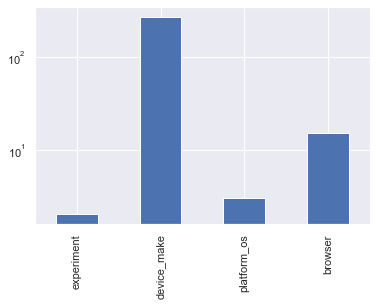

In [6]:
#the auction_id is the unique identifier for our dataset thus the huge number of unique values, 
#we'll exclude the column from our dataframe to have a better understanding of the data
BIO_data = data.drop(['auction_id'], axis=1)

#then we draw insights for categorical variables only in the remmaining data
BIO_data.select_dtypes(include='object').nunique().plot.bar(logy=True)

From the above bar plot, we can see that the feature device_make has the highest number of unique values followed by browser, platform_os and finally experiment. Experiment variable has the least value count since it's the two groups of users only.

### Frequency Plots using Bar Graph

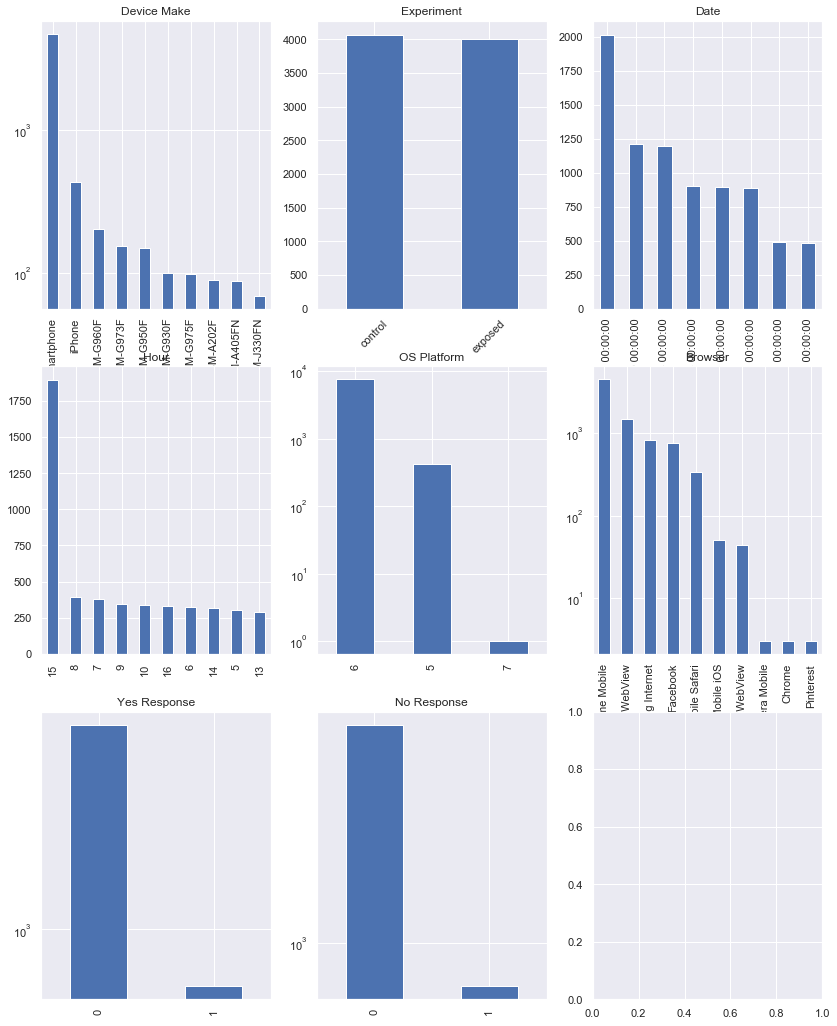

In [7]:
#columns = list(data)
#fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,18))

#for col, ax in enumerate(axes):
    #data[columns[col]].value_counts().nlargest(10).plot(kind='bar', title=columns[col])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,18))
#plt.xtick_labels(rotation=45)

data['device_make'].value_counts().nlargest(10).plot(ax=axes[0, 0], kind='bar',logy=True, title='Device Make')
data['experiment'].value_counts().plot(ax=axes[0, 1], kind='bar', title='Experiment', rot=45)
data['date'].value_counts().plot(ax=axes[0, 2], kind='bar', title='Date')
data['hour'].value_counts().nlargest(10).plot(ax=axes[1, 0], kind='bar', title='Hour')
data['platform_os'].value_counts().plot(ax=axes[1, 1], kind='bar', logy=True, title='OS Platform')
data['browser'].value_counts().nlargest(10).plot(ax=axes[1, 2], kind='bar', logy=True, title='Browser')
data['yes'].value_counts().plot(ax=axes[2, 0], kind='bar', logy=True, title='Yes Response')
data['no'].value_counts().plot(ax=axes[2, 1], kind='bar', logy=True, title='No Response')

From the above frequency plots using bar graphs, we can see that the data based on our two groups is almost equally distributed with the frequencies for control group and exposed group being close. It is also clear that `most users did not respond` to our questionnaire since the frequency for the `0` option is relatively high for both the `Yes` and `No` response. Our users are also using three OS platforms with their devices and most users seem to be using OS 6 platform. The response to the questionnaire is also `high for the first day` it was released, that is 2020-07-03, and `also towards the end` of the response period, on 2020-07-08 and 2020-07-09. Most users also responded to the questionnaire at `1500hrs` with the other hours of the day being approximately the same rate. Most users are also users of `Generic Smartphone` with `Chrome mobile browser`.

### Histogram
Histograms are great tool for showing distribution of variables, trend and possible skewness of data. We'll use them to understand our hour feature...

Text(0.5, 1.0, 'Distribution of Hour of response')

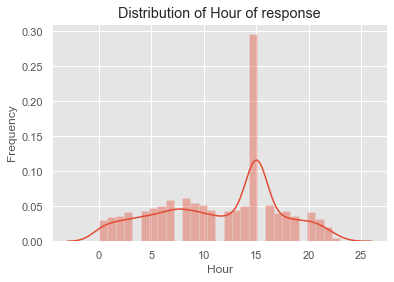

In [89]:
sns.distplot(data['hour'])
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Distribution of Hour of response')

The above histogram on hour of questionnairre view agrees with the frequency plots, showing an extraordinary higher questionnairre view at 1500hrs, with the rest of the data showing a slight skewness towards the morning hours.

### Relational Plots
Relational plots attempt to pinpoint any relatinship between two variables in the generation of a target variable. We'll utilize relational plots in this section to understand the relationship between the date and hour features in relation to our group's responses.

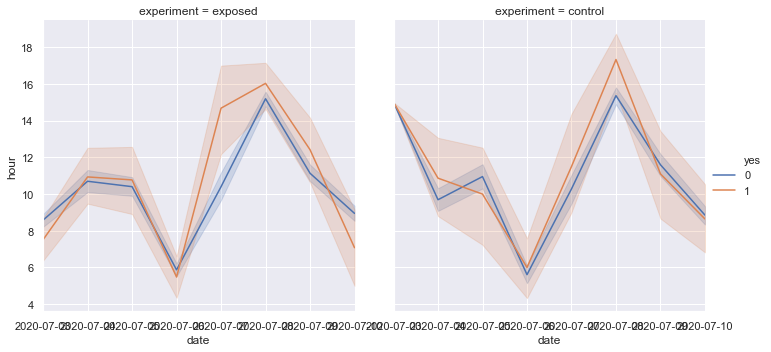

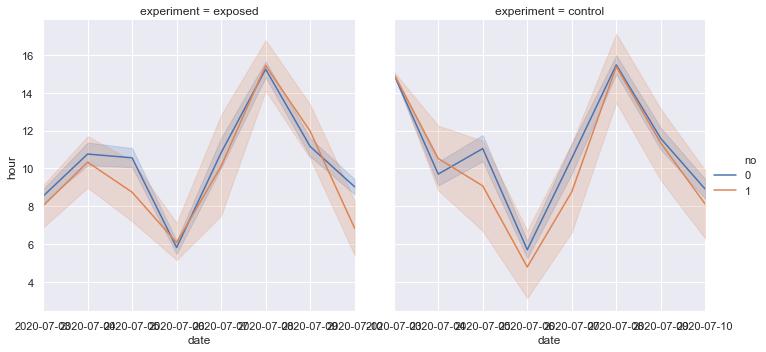

In [9]:
ax = sns.relplot(x='date', y='hour', data=data, col='experiment', hue='yes', kind='line')
ax.set(xlim=([datetime.date(2020, 7, 3), datetime.date(2020, 7, 10)]))

ax1 = sns.relplot(x='date', y='hour', data=data, col='experiment', hue='no', kind='line')
ax1.set(xlim=([datetime.date(2020, 7, 3), datetime.date(2020, 7, 10)]))

#date_form = DateFormatter("%d-%m")
#ax.set_major_formatter(date_form)

The above relational plots try to visualize the relationship between the date and hour features and the resonses of our experiment groups. The trend in all the four plots is similar with most users viewing and or responding to the qustionnaire early in the morning on 2020-07-06 and in the evening on 2020-07-08. The trend is also identical for 0 and 1 responses for both Yes and No among the experiment groups

## Classical A/B Testing
The principles of Classical A/B testing are quite easy to understand.
1. You define the baseline conversion rate and minimum detectable effect (MDE)
2. You calculate the sample size needed for a meaningful experiment using the metrics in step one along with statistical power and significance level
3. You drive traffic to your variations until you rech the target sample for each variation
4. Finally you evaluate the results of your A/B test.
If the difference in performance between variations reached MDE or exceeded it, the hypothesis of your experiment is proven right, otherwise, it's necessary to start the test from scratch.

For our scenario, we already have our data and sample size and we'll thus just define our metrics and evaluate the results of our test; we can also understand if our sample size and data is enough or if we need to run the test again with more data

In [57]:
import scipy.stats as scs

In [48]:
hypo_data = data.copy()
hypo_data['target'] = np.where(hypo_data['yes'] == 1, 1, 0)
hypo_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,target
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,0


#### A/B Testing Framework Functions

In [77]:
def pooled_prob(Control, Exposed, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (Control + Exposed)


def pooled_SE(Control, Exposed, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(Control, Exposed, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / Control + 1 / Exposed))
    return SE

def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z

def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

def ab_dist(stderr, mde=0, group_type='control'):
    """Returns a distribution object depending on group type
    Examples:
    Parameters:
        stderr (float): pooled standard error of two independent samples
        mde (float): the mean difference between two independent samples
        group_type (string): 'control' and 'exposed' are supported
    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'exposed':
        sample_mean = mde

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist

def p_val(Control, Exposed, p_A, p_B):
    """Returns the p-value for an A/B test"""
    return scs.binom(Control, C_cr).pmf(E_cr * Exposed)

#### Plotting Functions

In [78]:
def plot_norm_dist(ax, mu, std, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        std (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, std, sig_level=sig_level)

def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)
    
def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)


def plot_alt(ax, stderr, mde):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, mde=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, mde, stderr, label="Alternative")
    
def show_area(ax, mde, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, mde, 'exposed')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-5 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='blue', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='red', alpha='0.25',
                        where=(x < right))
        ax.text(-1 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

Main function for the hypothesis testing plot

In [79]:
def hypo_plot(Control, Exposed, bcr, mde, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, mde=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        mde: difference in conversion rate between the control and test
            groups. It is the **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_C = bcr * Control
    X_E = (bcr + mde) * Exposed
    stderr = pooled_SE(Control, Exposed, X_C, X_E)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, mde)

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, mde, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, mde, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, mde, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(Control, Exposed, bcr, bcr+mde)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

In [46]:
ab_data_summary = hypo_data.pivot_table(values='target', index='experiment', aggfunc=np.sum)
# add additional columns to the pivot table
ab_data_summary['total'] = hypo_data.pivot_table(values='target', index='experiment', aggfunc=lambda x: len(x))
ab_data_summary['rate'] = hypo_data.pivot_table(values='target', index='experiment')
ab_data_summary

,target,total,rate
experiment,,,
control,264,4071,0.064849
exposed,308,4006,0.076885


In [49]:
#initializing variables based on the summary above
#where C stands for Control, E stands for Exposed and cr stands for Conversation rate
C_aware = 264; C_total = 4071; C_cr = 0.065
E_aware = 308; E_total = 4006; E_cr = 0.077

We have a sample size of 4071 for control group and 4066 for exposed group. Approximating this sample, a bcr of `0.065` and using [this calculator](https://www.optimizely.com/sample-size-calculator/?conversion=6.5&effect=22.1&significance=95), we will use `0.221` as our mde for the experiment in order to detect the minimum change.

We then compare the two experiment groups by plotting the distribution of the control group and calculating the probability of getting the result from our exposed group. 

We can assume that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes, 'yes' or 'no' (similar to a coin flip).

Text(0, 0.5, 'probability')

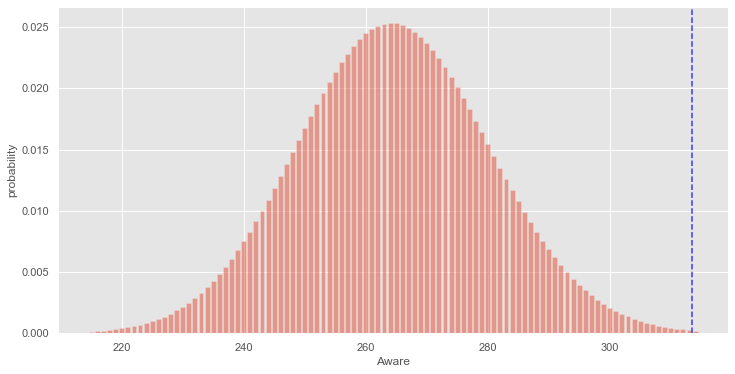

In [82]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(C_aware-49, C_aware+50, 100)
y = scs.binom(C_total, C_cr).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=E_cr * C_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('Aware')
plt.ylabel('probability')

The distribution for the control group is shown in red and the result from the exposed group is indicated by the blue dashed line. We can see that the probability of getting the result from the exposed group was very low. However, the probability does not convey the confidence level of the results. It does not take the sample size of our test group into consideration. 

Let’s continue and plot the test group results as a binomial distribution and compare the distributions against each other.

Text(0, 0.5, 'probability')

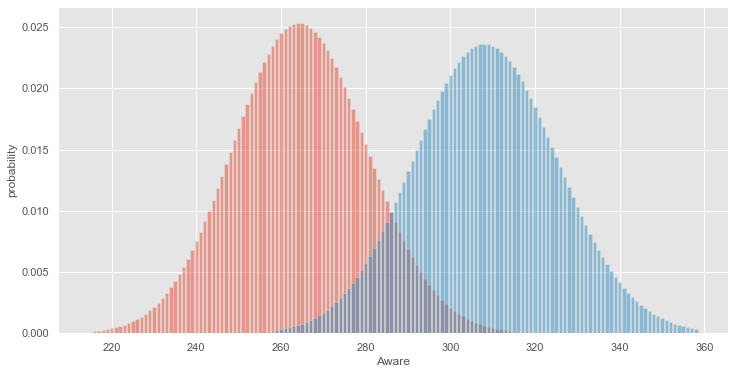

In [81]:
fig, ax = plt.subplots(figsize=(12,6))
xC = np.linspace(C_aware-49, C_aware+50, 100)
yC = scs.binom(C_total, C_cr).pmf(xC)
ax.bar(xC, yC, alpha=0.5)
xE = np.linspace(E_aware-49, E_aware+50, 100)
yE = scs.binom(E_total, E_cr).pmf(xE)
ax.bar(xE, yE, alpha=0.5)
plt.xlabel('Aware')
plt.ylabel('probability')

We can see that the two groups raised awareness in almost the same level but the control group raised awareness in slightly more users than the control group. We can also see that the peak of the exposed group results is lower than the control group.

### Compare the Null Hypothesis vs. the Alternative Hypothesis
Let’s start off by defining the null hypothesis and the alternative hypothesis.
* The null hypothesis is the position that the change in the SmartAd design made for the exposed group would result in no change in the conversion rate.
* The alternative hypothesis is the opposing position that the change in the SmartAd design for the exposed group would result in an improvement (or reduction) in the conversion rate.

Next, we plot the null and alternative hypotheses for the experiment and define the statistical power and the significance level by showing how they are represented in the plot of the null and alternative hypothesis.

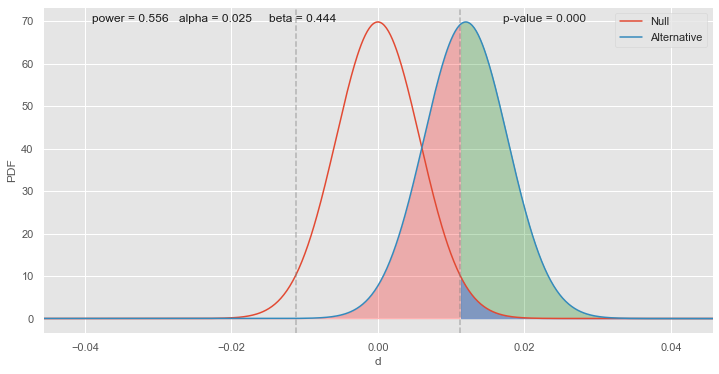

In [80]:
# define the parameters for hypo_plot() using the actual values from the experiment for bcr and mde
bcr = C_cr  
mde = E_cr - C_cr
hypo_plot(C_total, E_total, bcr, mde, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)

The green shaded area represents the `statistical power`. Statistical power is calculated by finding the area under the alternative hypothesis distribution and outside of the confidence interval of the null hypothesis.

The gray dashed lines in the plot above represent the confidence interval (95% for the plot above) for the null hypothesis. 

The area under the alternative hypothesis curve is equal to 1. If the alternative SmartAd design is truly better, the statistical power is the probability that we accept the alternative hypothesis and reject the null hypothesis (true positive).

The opposite area under the alternative curve is the probability that we accept the null hypothesis and reject the alternative hypothesis (false negative). This is `beta = 0.444` in A/B testing or hypothesis testing and is represented by the red shaded area.

The gray dashed line that divides the area under the alternative curve into two also directly segments the area associated with the `significance level = 0.025`, denoted with the greek letter `alpha`. If the null hypothesis is true and there truly is no difference between the control and exposed groups, then the significance level is the probability that we would reject the null hypothesis and accept the alternative hypothesis (false positive). A false positive is when we mistakenly conclude that the new SmartAd design is better. This value is low because we want to limit this probability.

Experiments are typically set up for a minimum desired power of 80%. If our new SmartAd design is truly better, we want our experiment to show that there is at least an 80% probability that this is the case. Unfortunately, our current experiment only has a `power of 0.556`.

**From the classical A/B testing, we can see that the brand awareness for our SmartAd campaign was not lifted significantly. Running another experiment might be costly but more data may show a difference in conversion rate.**

**Sticking with current data will mean a conclusion of non-significant lift in brand awareness and better to sticking with the dummy ad so as not to incur extra cost with uncertainities. Luckily, other testing method such as use of Machine Learning is available to do preditictions for the future.**

## Sequential A/B Testing
Sequential A/B testing gives us the chance to finish an experiment earlier without increasing the possibility of false results. The steps in one-sided Sequential A/B Testing include:
1. Choose sample size, N
2. Randomly assign variations under the test to the treatment and control groups with 50% probability each.
3. Track the number of incoming succeses from the treatment group, T
4. Track the number of incoming successes from the control group, C
5. If T-c reaches 2sqrtN, stop the test. Declare the treatment group as the winner.
6. If T+C reaches N, stop the test. Declare no winner

In [83]:
#@title
#REFERENCE
# A Conditional Sequential Test for the Equality of Two Binomial Proportions
# William Q. Meeker, Jr
# Journal of the Royal Statistical Society. Series C (Applied Statistics)
# Vol. 30, No. 2 (1981), pp. 109-115
def ConditionalSPRT(self,x,y,t1,alpha=0.05,beta=0.10,stop=None):
        if t1<=1:
            printLog('warning',"Odd ratio should exceed 1.")
        if (alpha >0.5) | (beta >0.5):
            printLog('warning',"Unrealistic values of alpha or beta were passed."
                     +" You should have good reason to use large alpha & beta values")
        if stop!=None:
            stop=math.floor(n0)

        def comb(n, k):
            return factorial(n) // factorial(k) // factorial(n - k)
        
        def lchoose(b, j):
            a=[]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                if len(j)<2:
                    j=j[0]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                for k in j:
                    n=b
                    if (0 <= k) & (k<= n):
                        a.append(math.log(comb(n,k)))
                    else:
                        a.append(0)
            else:
                n=b
                k=j
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)

            return np.array(a)

        def g(x,r,n,t1,t0=1):
            return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

        def h(x,r,n,t=1):
            return f(r,n,t,offset=ftermlog(x,r,n,t))

        def f(r,n,t,offset=0):
            upper=max(0,r-n)
            lower=min(n,r)
            rng=list(range(upper,lower+1))
            return np.sum(fterm(rng,r,n,t,offset))

        def fterm(j,r,n,t,offset=0):
            ftlog=ftermlog(j,r,n,t,offset)
            return np.array([math.exp(ex) for ex in ftlog])

        def ftermlog(j,r,n,t,offset=0):
            xx=r-j
            lch=lchoose(n,j)
            lchdiff=lchoose(n,xx)
            lg=np.array(j)*math.log(t)
            lgsum=lch+lchdiff
            lgsum2=lgsum+lg
            lgdiff=lgsum2-offset

            return lgdiff

        def logf(r,n,t,offset=0):

            z=f(r,n,t,offset)
            if z>0:
                return math.log(z)
            else:
                return np.nan

        def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
            offset=ftermlog(math.ceil(r/2),r,n,t1c)
            z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
            a=-math.log(alpha/(1-beta))
            b=math.log(beta/(1-alpha))
            lower=b
            upper=1+a
            return (np.array([lower,upper])+z)/math.log(t1c/t0)
            
        l=math.log(beta/(1-alpha))
        u=-math.log(alpha/(1-beta))
        sample_size=min(len(x),len(y))
        n=np.array(range(1,sample_size+1))

        if stop!=None:
            n=np.array([z for z in n if z<=stop])
        x1=np.cumsum(x[n-1])
        r=x1+np.cumsum(y[n-1])
        stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g

        clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
        limits=[]
        for v in clu:
            inArray=[]
            for vin in v:
                inArray.append(math.floor(vin))
            limits.append(np.array(inArray))
        limits=np.array(limits)

        k=np.where((stats>=u) | (stats<=l))
        cvalues=stats[k]
        if cvalues.shape[0]<1:
            k= np.nan
            outcome='Unable to conclude.Needs more sample.'
        else:
            k=np.min(k)
            if stats[k]>=u:
                outcome=f'Exposed group produced a statistically significant increase.'
            else:
                outcome='Their is no statistically significant difference between two test groups'
        if (stop!=None) & (k==np.nan):
            c1=clowerUpper(r,stop,t1,alpha,beta)
            c1=math.floor(np.mean(c1)-0.5)
            if x1[n0]<=c1:
                truncate_decision='h0'
                outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
            else:
                truncate_decision='h1'
                outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
            truncated=stop
        else:
            truncate_decision='Non'
            truncated=np.nan
        return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

In [85]:
import abc
import matplotlib.ticker as ticker
import sys

In [ ]:
## your code here. include other necessary functions as you want.
class SequentialTest:
    
    _metaclass_ = abc.ABCMeta
    def __init__(self,exposed,control, alpha=0.05, beta=0.2, h0=0, h1=1, values=[], variance=0):
        '''
        initialise startup variables
        '''
        # Input arguments
        self.alpha = alpha
        self.beta = beta
        self.h0 = h0
        self.h1 = h1
        self.values = values
        self.cum_values = np.cumsum(self.values)
        self.variance = variance
        # Necessary arguments
        self.upperCritical = np.log((1 - self.beta)/self.alpha)
        self.lowerCritical = np.log(self.beta/(1 - self.alpha))
        self.num_observation = len(values)
        self._seq_observation = np.array(range(1, self.num_observation + 1))
        self._x = np.array(range(0, self.num_observation + 2))
        self._yl = self._yu = np.ones(self.num_observation + 2)
        self.decision = None
        # Check the arguments
        self.__checkCommonArgs()
        self.__checkOtherArgs()
        # Calculate boundary
        self.calBoundary()
        # Sequential test
        self.seqTest()

    # Check common arguments in the fuction
    def __checkCommonArgs(self):

        if not all(0 < i < 1 for i in [self.alpha, self.beta]):

            sys.stderr.write("Type I error rate and type II error rate are between 0 and 1!")
            sys.exit(1)
        
    def stoppingRule(self, ...):
        '''
        This function should take current observation and return statistical decision made. 
        Consider truncate rule for longer tests
        '''

    def computeBoundaries(self,):
        '''
        This function shoud compute boundaries 
        '''

    def plot(self, boundaryColor=['#00aedb', '#d41243', '#000000'], pointColor='#000000', fill=True):
        '''
        showing the cumulative statistical test (e.g., log probability ratio) and the uper and lower limits.
        '''
        lowerBoundaryColor, upperBoundaryColor, continueColor = boundaryColor
        fig, ax = plt.subplots(figsize=(8, 6))
        lower_line, = ax.plot(self._x, self._yl, color=lowerBoundaryColor, linewidth=1, alpha=0.95)
        upper_line, = ax.plot(self._x, self._yu, color=upperBoundaryColor,  linewidth=1,  alpha=0.95)
        ax.scatter(self._seq_observation, self.cum_values, color=pointColor, zorder=1000, clip_on=False)
        yticks, yticklabels = plt.yticks()
        ymin = yticks[0]
        ymax = yticks[-1]
        if fill:

            ax.fill_between(self._x, self._yl, ymin, color=lowerBoundaryColor, alpha=0.5)
            ax.fill_between(self._x, self._yu, ymax, color=upperBoundaryColor, alpha=0.5)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        xticks, xticklabels = plt.xticks()
        xmin = 0.95
        xmax = self.num_observation + 0.05
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.xlabel("Observations")
        plt.ylabel("Cumulative Sum")
        plt.legend(handles=[upper_line, lower_line], labels=["Reject Null", "Accept Null"], fontsize=10, loc=2)
        plt.show()

    def plotBoundaries(self, boundaryColor=["#00aedb", "#d41243"], fill=True):
        '''cumulative sums of exposed successes, bounded by the critical limits.
        '''
        lowerBoundaryColor, upperBoundaryColor = boundaryColor
        fig, ax = plt.subplots(figsize=(8,6))
        lower_line, = ax.plot(self._x, self.y1, color=lowerBoundaryColor, linewidth=1)
        upper_line, = ax.plot(self._x, self.yu, color=upperBoundaryColor, linewidth=1)
        yticks, yticklabels = plt.yticks()
        ymin = yticks[0]
        ymax = yticks[-1]
    
        if fill:
            ax.fill_between(self._x, self._y1, ymin, color=lowerBoundaryColor, alpha=0.5)
            ax.fill_between(self._x, self._yu, ymax, color=upperBoundaryColor, alpha=0.5)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.xlim(1, self.num_observation)
        plt.ylim(ymin, ymax)
        plt.xlabel('Observations')
        plt.ylabel('Cumulative Sum')
        plt.legend(handles = [upper_line, lower_line], labels = ['Reject Null', 'Accept Null'], fontsize = 10, loc = 2)
        plt.show()

    # Get test result
    def getResult(self, nobs=5, start="end"):

        print("Decision:\t" + self.decision + "\n")
        output_dict = {'values': self.cum_values, 'lower': self.lowerBoundary, 'upper': self.upperBoundary}
        output_df = pd.DataFrame(output_dict, columns=['values', 'lower', 'upper'], index=self._seq_observation)
        output_df.index.name = "n"
        print(output_df.round(3).iloc[-nobs:])

    # Sequential test
    def seqTest(self):

        self.test_statistic = self.cum_values[self.num_observation - 1]
        if self.test_statistic > self.upperBoundary[self.num_observation - 1]:

            self.decision = "Reject"

        elif self.test_statistic < self.lowerBoundary[self.num_observation - 1]:

            self.decision = "Accept"

        else:

            self.decision = "Continue"

        header = 10 if self.num_observation > 10 else self.num_observation
        self.getResult(nobs=header)

    # Abstract method, calculate the boundary by time
    @abc.abstractmethod
    def calBoundary(self):

        return

In [ ]:
def transform_data(df):
  '''
  segment data into exposed and control groups
  consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
  create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
  '''
  return exposed,control

def plotDataSummary(exposed, control):
  'This function plots cummulated success'

def pretyPrintTestResult(self, test):
  '''This function print final test result. Json format is recommended. For example
  {
    "name": "",
    "engagementCountControl": ,
    "engagementCountExposed": ,
    "positiveCountControl": ,
    "positiveCountExposed": ,
    "ControlSuccessProbability": ,
    "ExposedSuccessProbability": ,
    "basePositiveRate": ,
    "significanceSign": ".",
    "lift": ,
    "oddRatio": ,
    "exactSuccessOddRate":,
    "confidenceIntervalLevel": ,
    "alpha": ,
    "beta": ,
    "power": ,
    "criticalValue": ,
    "lower critical(a)": 
    "upper critical(b)": ,
    "TotalObservation": 
  }'''

In [ ]:

######################################
'Define statistical parameters such as alpha, beta, sample size if evan approach is used, odd ratio for SPRT'
alpha=
beta=
#other variables here
'Compute statistical lower and upper decision points such as a and b'
a=
b=
#other variables here

##data processing here
exposed,control=transform_data(data)
##plot data summary
plotDataSummary(exposed,control)

'Perform test. Loop over each of data entry and perform test. Accumulate result into dataframe and print out test journey'
test=SequentialTest(...)

'Print test result.'
pretyPrintTestResult(resultObject)

# A/B Testing using Machine Learning
Machine Learning further automates A/B testing using dfferent algorithmms. The following is an approach to A/B testing using Machine Learning.

Our problem is best framed as a binary classification (Yes or No response to a questionnaire), which predicts whether the advertising campaign conducted by SmartAd resulted in a significant lift in brand awareness or not.
Our dataset consists of 8077 users who were shown a dummy ad or a creative, online interactive ad with the SmartAd brand randomly; with the Yes or No response to the questionnaire and the date and hour of their response, and the users' device, platform OS, and browser used to view the questionnaire.
Each user, uniquely identified by an impression id, is given a label out of three possible options (aware, not aware, no response), based on their response.
Our target is to predict brand awareness, represented by the `Yes` response, therefore, our target variable is the yes feature.

We start with importing the necessary modules first...

In [10]:
from sklearn import linear_model
from sklearn import preprocessing as ppr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.style.use('ggplot')

### Helper Functions
* Function for labelencoding multiple columns since most of out data features are non-numerical
* Function for printing the evaluation scores, ie. Root Mean Squared Error, R2 Score, and Mean Absolute Error
* Function for plotting the original values and values predicted by the model.

In [11]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = ppr.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = ppr.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [12]:
def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    
    print('RMSE Score : {:.2f}'.format(rmse), '\nR2_Squared : {:.2f}'.format(r_sq), '\nMAE Score : {:.2f}'.format(mae))

In [13]:
def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize = (14, 7))
    original = plt.scatter(np.arange(1, N+1), y_test, c = 'blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c = 'red')
    plt.xticks(np.arange(1, N+1), rotation=45)
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title('True labels vs. Predicted labels ({})'.format(model_name))
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

## Training and Testing Sets
First, we split our data into training and testing sets with a 90% - 10% ratio using `train_test_split` function from sklearn library.

In [14]:
ML_data = data.drop(['auction_id','date'], axis=1)
#ML_data['target'] = np.where(ML_data['yes'] == 1, 'Aware', (np.where(ML_data['no'] == 1, 'Not Aware', 'No Response')))
ML_data['target'] = np.where(ML_data['yes'] == 1, 1, 0)


ML_data = MultiColumnLabelEncoder(columns = ['experiment','device_make','platform_os','browser']).fit_transform(ML_data)
# define the target variable (dependent variable) as y
y = ML_data.target 

ML_data = ML_data.drop(['yes','no','target'], axis=1)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(ML_data, y, test_size=0.1, random_state=0)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(7269, 5) (7269,)
(808, 5) (808,)


## Implementing Machine Learning Algorithms
Next, we apply machine learning to the training data using the following different algorithms.
* Linear Regression
* Logistic Regression
* Decision Trees
* XGBoost

### Linear Regression

RMSE Score : 0.24 
R2_Squared : -0.01 
MAE Score : 0.13


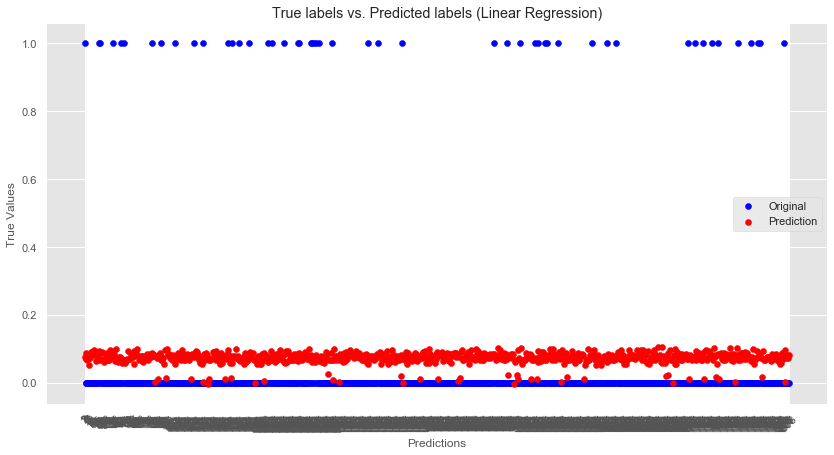

In [15]:
# fit a model on the training data
lm = linear_model.LinearRegression()
lreg_model = lm.fit(X_train, y_train)

#make predictions using test data
lreg_y_pred = lm.predict(X_test)

#calculating RMSE and R2 Score
#mse = mean_squared_error(y_test, lreg_y_pred)
#rmse = np.sqrt(mse)
#r2_score = lreg_model.score(X_test, y_test)

calculate_metrics(y_test, lreg_y_pred)

#print('Mean Square Error is :',mse,'\nRoot Mean Square Error is :',rmse,' \nR squared Score is :', r2_score)

#plotting the model
## The line / model
#plt.scatter(y_test, lreg_y_pred)
#plt.xlabel('True Values')
#plt.ylabel('Predictions')

plot_preds(y_test, lreg_y_pred, 'Linear Regression')

### 5-fold Cross Validation
In K-Folds Cross Validation, we split our data into  different subsets. We use k-1 subsets to train our data and leave the last subset as test data. We the average the model against each of the subsets and then finalize our model. After that we test it against the test test. This approach solves the biasness in the train-test model in case the splitting wasn't randomized, therefore, avoiding overfitting of our model.

We will, thus, perform a 5-fold cross-validation on each of our models.

In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

Cross-validated scores: [ 0.00276614 -0.00063144  0.00179582  0.000671    0.00381065]


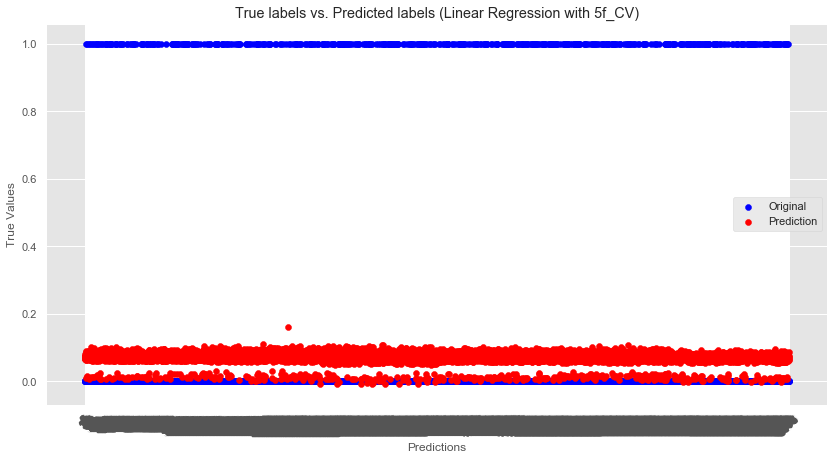

In [17]:
# Perform 5-fold cross validation
lreg_cv_scores = cross_val_score(lreg_model, ML_data, y, cv=5)
print('Cross-validated scores:', lreg_cv_scores)

# Make cross validated predictions
lreg_cv_y_pred = cross_val_predict(lreg_model, ML_data, y, cv=6)
plot_preds(y, lreg_cv_y_pred, 'Linear Regression with 5f_CV')

In [238]:
pd.DataFrame(lm.feature_importances_.reshape(1, -1), columns=list(ML_data))

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

### Logistic Regression

Accuracy of logistic regression classifier on test set: 0.94
RMSE Score : 0.25 
R2_Squared : -0.07 
MAE Score : 0.06


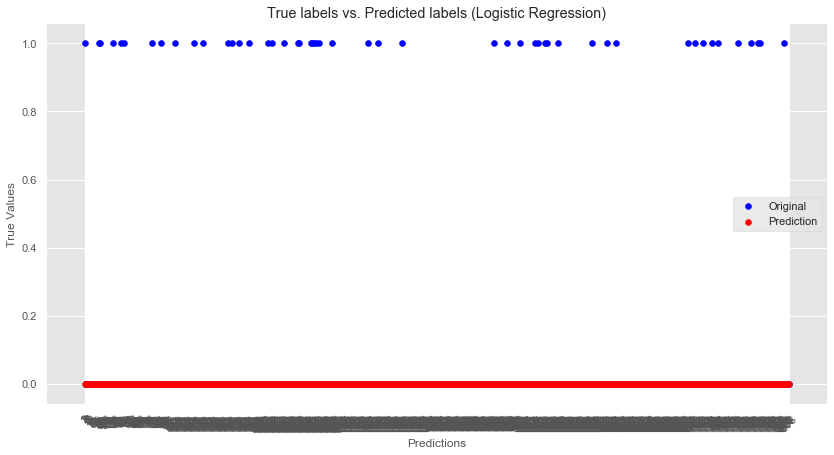

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg_model = logreg.fit(X_train, y_train)

logreg_y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

#calculating metrics
calculate_metrics(y_test, logreg_y_pred)

#plotting the model
plot_preds(y_test, logreg_y_pred, 'Logistic Regression')

Cross-validated scores: [0.92883663 0.92883663 0.92941176 0.92941176 0.92941176]


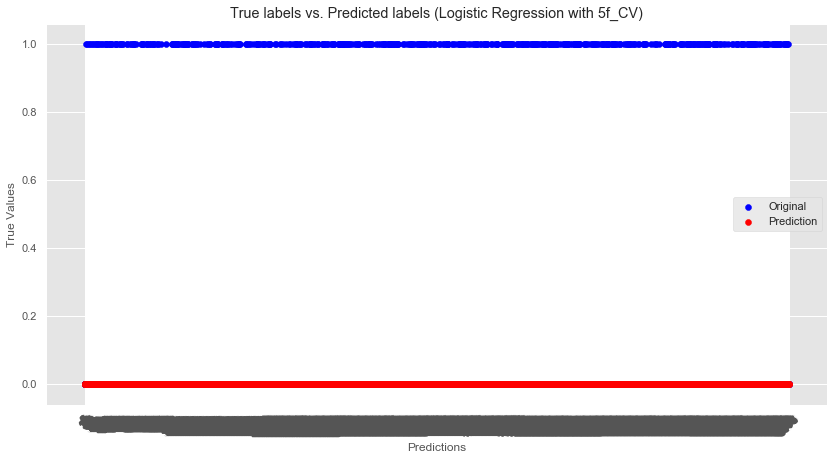

In [19]:
# Perform 5-fold cross validation
logreg_cv_scores = cross_val_score(logreg_model, ML_data, y, cv=5)
print('Cross-validated scores:', logreg_cv_scores)

# Make cross validated predictions
logreg_cv_y_pred = cross_val_predict(logreg_model, ML_data, y, cv=6)
plot_preds(y, logreg_cv_y_pred, 'Logistic Regression with 5f_CV')

In [237]:
pd.DataFrame(logreg.feature_importances_.reshape(1, -1), columns=list(ML_data))

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

### Decision Trees

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
import pydotplus

C:\Users\kiiru\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


[[736  22]
 [ 50   0]]
RMSE Score : 0.30 
R2_Squared : -0.53 
MAE Score : 0.09


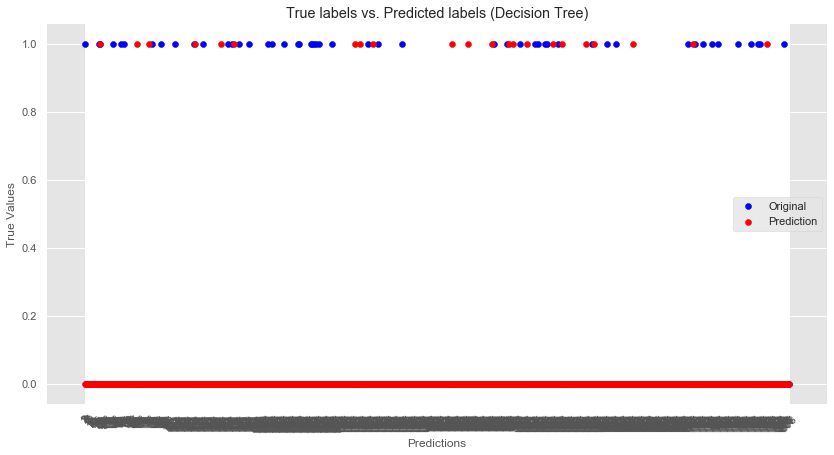

In [30]:
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train, y_train)

dt_y_pred = dt.predict(X_test)

awareness = np.array(y_test)
dt_predictions = np.array(dt_y_pred)
print(confusion_matrix(awareness, dt_predictions))

calculate_metrics(y_test, dt_y_pred)

plot_preds(y_test, dt_y_pred, 'Decision Tree')

Cross-validated scores: [0.90779703 0.90655941 0.91083591 0.90526316 0.90897833]


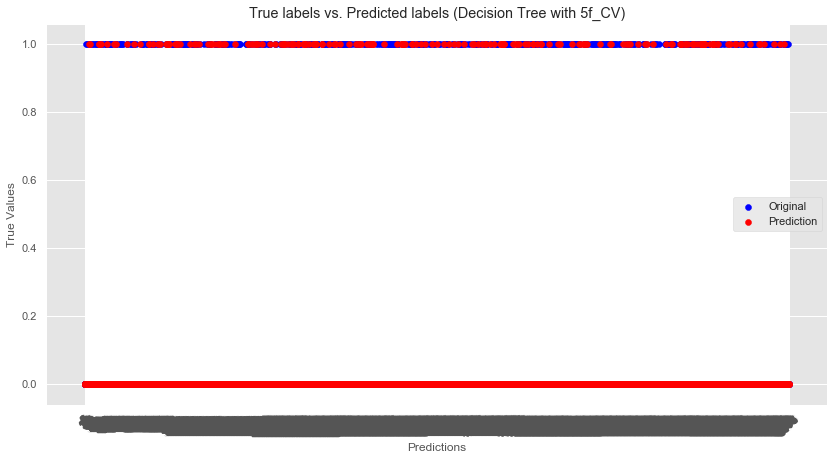

In [22]:
# Perform 5-fold cross validation
dt_cv_scores = cross_val_score(dt_model, ML_data, y, cv=5)
print('Cross-validated scores:', dt_cv_scores)

# Make cross validated predictions
dt_cv_y_pred = cross_val_predict(dt_model, ML_data, y, cv=6)
plot_preds(y, dt_cv_y_pred, 'Decision Tree with 5f_CV')

In [23]:
pd.DataFrame(dt.feature_importances_.reshape(1, -1), columns=list(ML_data))

,experiment,hour,device_make,platform_os,browser
0,0.037944,0.332414,0.49959,0.000124,0.129928


From the above information it is clear that the device_make feature is highly driving the Decision Tree model followed by the hour feature. On the other hand, the feature platform_os has little impact on the prediction of our model.

In [24]:
dot_data = StringIO()
export_graphviz(dt, out_file = dot_data, feature_names=ML_data.columns, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

### XGBoost

In [25]:
import xgboost as xgb

[11:11:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE Score : 0.24 
R2_Squared : -0.02 
MAE Score : 0.13


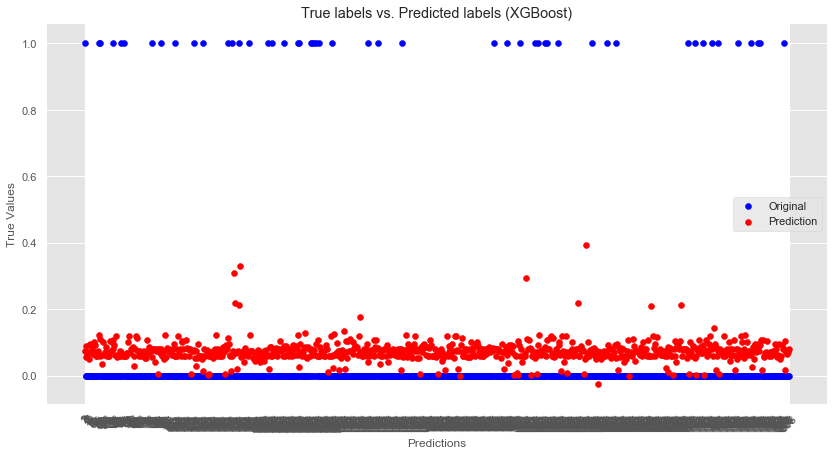

In [26]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

xg_model = regressor.fit(X_train, y_train)

xg_y_pred = regressor.predict(X_test)

calculate_metrics(y_test, xg_y_pred)

plot_preds(y_test, xg_y_pred, 'XGBoost')

[11:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross-validated scores: [-0.0011754  -0.02153261 -0.00178522 -0.00498834 -0.00318391]
[11:14:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

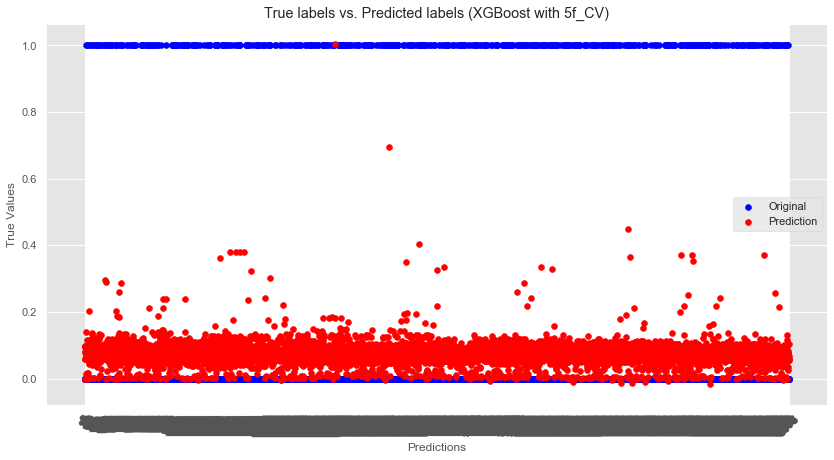

In [27]:
# Perform 5-fold cross validation
xg_cv_scores = cross_val_score(xg_model, ML_data, y, cv=5)
print('Cross-validated scores:', xg_cv_scores)

# Make cross validated predictions
xg_cv_y_pred = cross_val_predict(xg_model, ML_data, y, cv=6)
plot_preds(y, xg_cv_y_pred, 'XGBoost with 5f_CV')

In [28]:
pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=list(ML_data))

,experiment,hour,device_make,platform_os,browser
0,0.215099,0.22264,0.305186,0.0,0.257074


The above information shows that the device_make feature is driving the XGBoost model as well. It also shows 0 importaince of the platform_os feature in our model. The experiment, hour and browser features also have a significant effect on the preditiction of the model.

Using Mean Squared Error, R2 Score and Mean Absolute Error loss functions, we can understand how our different models compare. The values for our models are relatively similar among the Linear Regression, Logistic Regression, and XGBoost models. Decision Tree model deviates a little bit further from the other models, also visible in its predictions since it's the only model that has predictions on a number of Yes responses with the rest having none.

## Conclusion
From the above models, the predictions are skewed towards the No response and this indicates a low lift in the brand awareness of the SmartAd advertising campaign.

From our data, the device_make feature seems to be the most important predictor variable followed closely by the browser and hour features.

Both A/B testing and Machine Learning is used in our project to further the understanding of our hypothesis. While A/B testing uses statistical parameters to test the hypothesis, Machine Learnign used different algorithms along with loss functions to do predictions based on our data understand the metrics.
While A/B testing focuses on understanding the data at hand, Machine learning uses the data at hand to do forecasts for the future. With Machine Learning we understand what the future looks like for our variants and may prevent premature decision-making based on A/B testing only.

## Refrences
1. [A/B Testing with Machine Learning - A Step-by-Step Tutorial](https://www.business-science.io/business/2019/03/11/ab-testing-machine-learning.html)
2. [Simple Sequential A/B Testing](https://www.evanmiller.org/sequential-ab-testing.html)
3. [XGBoost Python Example](https://towardsdatascience.com/xgboost-python-example-42777d01001e)
4. [Decision Tree in Python](https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93)
5. [Formulate your Problem as a Machine Learning Problem](https://developers.google.com/machine-learning/problem-framing/formulate)